In [1]:
import os
from pathlib import Path
import numpy as np
from scipy.sparse import coo_array
import skimage.exposure
from scipy.sparse import coo_matrix
import warnings
from io import StringIO

def _read_roi(path: Path, shape) -> coo_matrix:
    """
    读取 ENVI 软件导出 ROI 文件的 txt 文件，生成一个稀疏矩阵，表示每个像素点的类别标签。
    
    :param path: 文件路径，ENVI ROI 文件的路径
    :param shape: 图像的形状（height, width）
    :return: 一个稀疏矩阵，非零值表示像素点的类别标签
    """
    warnings.simplefilter("ignore", category=UserWarning)  # 忽略 loadtxt 的警告
    data = []
    rows = []
    cols = []
    current_label = 0
    buffer = ""

    with open(path, 'r') as f:
        for line in f:
            # 判断是否为新 ROI 的分割点
            if line.strip() == "" or line.startswith(";") or "ROI" in line:
                if buffer:  # 如果缓冲区有内容，解析为坐标数据
                    roi_data = np.loadtxt(StringIO(buffer), usecols=(2, 1), dtype=int)
                    if roi_data.size > 0:
                        r, c = roi_data.T
                        rows.extend(r)
                        cols.extend(c)
                        data.extend([current_label] * len(r))
                    buffer = ""  # 清空缓冲区
                # 如果遇到 ROI name 行，增加类别标签
                if "ROI name" in line:
                    current_label += 1
            else:
                buffer += line  # 将数据加入缓冲区

        # 处理最后一个 ROI
        if buffer:
            roi_data = np.loadtxt(StringIO(buffer), usecols=(2, 1), dtype=int)
            if roi_data.size > 0:
                r, c = roi_data.T
                rows.extend(r)
                cols.extend(c)
                data.extend([current_label] * len(r))

    warnings.resetwarnings()

    # 创建稀疏矩阵
    img = coo_matrix((data, (rows, cols)), shape=shape, dtype=int)
    return img


def sample_train_from_candidate(candidate_truth, num_per_class=10, seed=42):
    """
    从 candidate_truth 中每个类别随机抽取固定数量作为新的训练样本。
    
    参数:
        candidate_truth: coo_matrix, 原始训练稀疏标签
        num_per_class: int, 每类抽取数量
        seed: int, 随机种子

    返回:
        train_truth: coo_matrix, 新的训练样本矩阵
    """
    np.random.seed(seed)

    rows, cols, labels = candidate_truth.row, candidate_truth.col, candidate_truth.data
    new_rows, new_cols, new_labels = [], [], []

    unique_classes = np.unique(labels)
    for cls in unique_classes:
        indices = np.where(labels == cls)[0]
        if len(indices) < num_per_class:
            raise ValueError(f"类 {cls} 样本不足，只有 {len(indices)} 个，无法抽取 {num_per_class} 个")
        chosen = np.random.choice(indices, num_per_class, replace=False)
        new_rows.extend(rows[chosen])
        new_cols.extend(cols[chosen])
        new_labels.extend(labels[chosen])

    shape = candidate_truth.shape
    train_truth = coo_matrix((new_labels, (new_rows, new_cols)), shape=shape, dtype=int)
    return train_truth
def load_houston2013(data_path: Path):
    """
    从本地路径加载 Houston2013 数据集。

    :param data_path: 数据集的根目录路径。
    :return: (casi, lidar, train_truth, test_truth, info)
    """
    FILES_PATH = data_path
    assert FILES_PATH.exists(), f"{FILES_PATH} does not exist. Please check the path."

    # 加载图像数据
    lidar = skimage.io.imread(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_LiDAR.tif')[np.newaxis, :, :]  # (1, 349, 1905)
    casi = skimage.io.imread(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_CASI.tif').transpose(2, 0, 1)   # (144, 349, 1905)

    # 加载训练集和测试集的真值
    train_truth = _read_roi(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_Samples_TR.txt', (349, 1905))
    test_truth = _read_roi(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_Samples_VA.txt', (349, 1905))

    # 数据集元信息
    info = {
        'n_band_casi': 144,
        'n_band_lidar': 1,
        'width': 1905,
        'height': 349,
        'label_dict': {
            1: 'Healthy grass',
            2: 'Stressed grass',
            3: 'Synthetic grass',
            4: 'Trees',
            5: 'Soil',
            6: 'Water',
            7: 'Residential',
            8: 'Commercial',
            9: 'Road',
            10: 'Highway',
            11: 'Railway',
            12: 'Parking Lot 1',
            13: 'Parking Lot 2',
            14: 'Tennis Court',
            15: 'Running Track',
        }
    }
    # 原始 train_truth 作为候选样本
    candidate_truth = train_truth

    # 从候选中随机抽样为正式训练集
    train_truth = sample_train_from_candidate(candidate_truth, num_per_class=15)

    return casi, lidar, train_truth, candidate_truth, test_truth, info


# 指定数据集路径
data_path = Path(r"E:\code\-\对比学习\fx\Houston2013\2013_DFTC")

# 加载数据集
casi, lidar, train_truth, candidate_truth, test_truth, info = load_houston2013(data_path)

# 打印数据集基本信息
print(f"CASI shape: {casi.shape}")   # 高光谱图像 (144, 349, 1905)
print(f"LiDAR shape: {lidar.shape}")  # LiDAR 数据 (1, 349, 1905)
print(f"Train truth non-zero: {train_truth.count_nonzero()}")  # 训练集非零样本数
print(f"Test truth non-zero: {test_truth.count_nonzero()}")    # 测试集非零样本数
print(f"Label dictionary: {info['label_dict']}")


<tifffile.TiffPage 0 @2949772> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')


CASI shape: (144, 349, 1905)
LiDAR shape: (1, 349, 1905)
Train truth non-zero: 225
Test truth non-zero: 12197
Label dictionary: {1: 'Healthy grass', 2: 'Stressed grass', 3: 'Synthetic grass', 4: 'Trees', 5: 'Soil', 6: 'Water', 7: 'Residential', 8: 'Commercial', 9: 'Road', 10: 'Highway', 11: 'Railway', 12: 'Parking Lot 1', 13: 'Parking Lot 2', 14: 'Tennis Court', 15: 'Running Track'}


In [ ]:
# 统计 train_truth 中的类别数量（非零值的唯一值数量）
num_classes = len(set(train_truth.data))


15

In [3]:
from scipy.sparse import coo_matrix

def merge_train_test(train_truth, test_truth, shape):
    """
    合并训练集和测试集稀疏矩阵为一个新的训练集矩阵。
    
    参数:
        train_truth: coo_matrix, 原始训练集稀疏矩阵
        test_truth: coo_matrix, 原始测试集稀疏矩阵
        shape: tuple, 数据的形状 (height, width)
        
    返回:
        merged_truth: coo_matrix, 合并后的训练集稀疏矩阵
    """
    # 合并行、列和数据
    merged_rows = np.concatenate([train_truth.row, test_truth.row])
    merged_cols = np.concatenate([train_truth.col, test_truth.col])
    merged_data = np.concatenate([train_truth.data, test_truth.data])
    
    # 创建新的稀疏矩阵
    merged_truth = coo_matrix((merged_data, (merged_rows, merged_cols)), shape=shape)
    return merged_truth

# 合并训练集和测试集为新的训练集
merged_train_truth = merge_train_test(train_truth, test_truth, (349, 1905))
merged_train_truth



<349x1905 sparse matrix of type '<class 'numpy.int32'>'
	with 12422 stored elements in COOrdinate format>

In [30]:
from sklearn.decomposition import PCA
import numpy as np


def apply_pca_on_candidate(hsi_data, candidate_truth, num_components=40, use_pca=True):
    """
    在 candidate_truth 区域进行 PCA 或保留原始光谱，返回结果格式统一。

    返回：
    - data: shape [C, H, W]，只在候选区域填值，其余为 0
    - samples: shape [N, C]，候选像素的特征
    - coords: List of (row, col)
    - explained_variance_ratio 或 None
    """
    c, h, w = hsi_data.shape
    rows, cols = candidate_truth.row, candidate_truth.col
    spectra = hsi_data[:, rows, cols].T  # shape: (N, C)

    coords = list(zip(rows, cols))

    if use_pca:
        pca = PCA(n_components=num_components)
        reduced = pca.fit_transform(spectra)  # shape: (N, num_components)
        result_c = num_components
        final_data = reduced
        var_ratio = pca.explained_variance_ratio_
    else:
        reduced = spectra  # shape: (N, C)
        result_c = c
        final_data = reduced
        var_ratio = None

    # 构建 [C, H, W] 格式，只填候选区域
    candidate_data = np.zeros((result_c, h, w), dtype=np.float32)
    for i, (r, c_) in enumerate(coords):
        candidate_data[:, r, c_] = final_data[i]

    return candidate_data, reduced, coords, var_ratio
com =60
# 应用 PCA 降维
pca_data, reduced_samples, coords, var_ratio = apply_pca_on_candidate(casi, candidate_truth, num_components=com)

print(f"PCA 降维后的数据形状: {pca_data.shape}")  # (40, 349, 1905)
print(f"PCA 累计解释方差比: {np.sum(var_ratio):.4f}")  




PCA 降维后的数据形状: (60, 349, 1905)
PCA 累计解释方差比: 1.0000


In [31]:
import torch
def split_cube(hsi_cube):
    """
    将高光谱立方块沿通道维度均匀切分。
    参数:
        hsi_cube: torch.Tensor, 形状为 [H, W, C]
    返回:
        hsi_cube_a, hsi_cube_b: 两个子立方块
    """
    _, _, c = hsi_cube.shape
    c1 = c // 2  # 每个子块保留一半的通道
    return hsi_cube[:, :, :c1], hsi_cube[:, :, c1:]

# 提取 11x11 的立方块
s = 11  # 立方块的宽和高
patch_size = (s, s)

def extract_cube(data, x, y, size):
    """
    从高光谱图像中提取一个立方块，并在边缘不足时进行填充。
    参数:
        data: 高光谱数据, 形状为 [C, H, W]
        x, y: 中心像素的坐标
        size: 立方块的大小 (s, s)
    返回:
        cube: 提取的立方块, 形状为 [C, s, s]
    """
    c, h, w = data.shape
    half_size = size[0] // 2
    x_min = max(0, x - half_size)
    x_max = min(h, x + half_size + 1)
    y_min = max(0, y - half_size)
    y_max = min(w, y + half_size + 1)
    
    cube = data[:, x_min:x_max, y_min:y_max]

    # 进行对称填充，确保形状为 (C, s, s)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (max(0, half_size - x), max(0, x + half_size + 1 - h)),  # 高度填充
        (max(0, half_size - y), max(0, y + half_size + 1 - w)),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="reflect")
    return cube

# 提取某像素点周围的立方块
x, y = 100, 100  # 中心像素位置
cube = extract_cube(pca_data, x, y, patch_size)
print("提取的立方块形状:", cube.shape)  # (40, 11, 11)
# 切分通道
cube_tensor = torch.tensor(cube).permute(1, 2, 0)  # 转换为 [H, W, C]
cube_a, cube_b = split_cube(cube_tensor)

print("子立方块 A 形状:", cube_a.shape)  # (11, 11, 20)
print("子立方块 B 形状:", cube_b.shape)  # (11, 11, 20)


提取的立方块形状: (60, 11, 11)
子立方块 A 形状: torch.Size([11, 11, 30])
子立方块 B 形状: torch.Size([11, 11, 30])


In [32]:
import torch.nn as nn
import torch.nn.functional as F

class FeatureExtractor(nn.Module):
    def __init__(self, input_channels=20):
        """
        特征提取网络。
        参数:
            input_channels: 输入的通道数，例如 20。
        """
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)  # 第一层卷积
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 第二层卷积
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 第三层卷积
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)  # 最大池化层
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 卷积 + 批归一化 + 激活 + 池化
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # 展平特征


In [7]:
print(cube_a.dtype, cube_a.device)
print(cube_b.dtype, cube_b.device)


torch.float32 cpu
torch.float32 cpu


In [33]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=128, output_dim=8):
        """
        特征投影模块。
        参数:
            input_dim: 输入特征的维度，例如 128。
            output_dim: 投影后的维度，例如 8。
        """
        super(ProjectionHead, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.normalize(self.fc(x), dim=1)  # 投影后的特征归一化


def contrastive_loss(features_a, features_b, temperature=1.0):
    """
    计算对比损失。
    参数:
        features_a, features_b: 投影后的特征，形状为 [batch_size, projection_dim]
        temperature: 温度系数
    返回:
        loss: 对比损失值
    """
    batch_size = features_a.size(0)
    features = torch.cat([features_a, features_b], dim=0)  # 拼接特征
    sim_matrix = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)  # 计算相似度
    sim_matrix = sim_matrix / temperature

    # 构造标签
    labels = torch.arange(batch_size, device=features_a.device)
    labels = torch.cat([labels, labels], dim=0)

    # 使用交叉熵损失
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

def contrastive_loss_ce_hard_negatives(features_a, features_b, temperature=0.1, num_negatives=2):
    """
    Cross-Entropy Contrastive Loss using hardest negative sampling.
    - Each anchor (features_a[i]) uses its positive (features_b[i])
    - Negatives are selected as least similar samples in [features_a; features_b]
    """

    batch_size = features_a.size(0)

    # Normalize
    features_a = F.normalize(features_a, dim=1)
    features_b = F.normalize(features_b, dim=1)

    # Combine: total 2N candidates
    all_features = torch.cat([features_a, features_b], dim=0)  # [2N, D]

    # Cosine sim between anchors and all
    sim_matrix = torch.matmul(features_a, all_features.T) / temperature  # [N, 2N]

    # Mask out own positive (at i + batch_size)
    pos_indices = torch.arange(batch_size, device=features_a.device)
    sim_matrix[torch.arange(batch_size), pos_indices + batch_size] = float('-inf')

    # Select top-k lowest similarity (hard negatives)
    _, neg_indices = torch.topk(sim_matrix, k=num_negatives, dim=1, largest=False)  # [N, k]

    # Construct new logits: [N, 1 + k] → positive + k negatives
    pos_sim = torch.sum(features_a * features_b, dim=1, keepdim=True) / temperature  # [N, 1]
    neg_sims = torch.gather(sim_matrix, 1, neg_indices)  # [N, k]
    logits = torch.cat([pos_sim, neg_sims], dim=1)  # [N, 1+k]

    # Labels: positive is index 0
    labels = torch.zeros(batch_size, dtype=torch.long, device=features_a.device)

    loss = F.cross_entropy(logits, labels)
    return loss

Epoch [1/50], Loss: 0.5007
Epoch [2/50], Loss: 0.4428
Epoch [3/50], Loss: 0.4396
Epoch [4/50], Loss: 0.4382
Epoch [5/50], Loss: 0.4372
Epoch [6/50], Loss: 0.4365
Epoch [7/50], Loss: 0.4361
Epoch [8/50], Loss: 0.4359
Epoch [9/50], Loss: 0.4356
Epoch [10/50], Loss: 0.4354
Epoch [11/50], Loss: 0.4355
Epoch [12/50], Loss: 0.4352
Epoch [13/50], Loss: 0.4351
Epoch [14/50], Loss: 0.4351
Epoch [15/50], Loss: 0.4350
Epoch [16/50], Loss: 0.4349
Epoch [17/50], Loss: 0.4349
Epoch [18/50], Loss: 0.4348
Epoch [19/50], Loss: 0.4348
Epoch [20/50], Loss: 0.4348
Epoch [21/50], Loss: 0.4347
Epoch [22/50], Loss: 0.4347
Epoch [23/50], Loss: 0.4347
Epoch [24/50], Loss: 0.4347
Epoch [25/50], Loss: 0.4346
Epoch [26/50], Loss: 0.4346
Epoch [27/50], Loss: 0.4346
Epoch [28/50], Loss: 0.4346
Epoch [29/50], Loss: 0.4345
Epoch [30/50], Loss: 0.4346
Epoch [31/50], Loss: 0.4345
Epoch [32/50], Loss: 0.4345
Epoch [33/50], Loss: 0.4345
Epoch [34/50], Loss: 0.4345
Epoch [35/50], Loss: 0.4346
Epoch [36/50], Loss: 0.4345
E

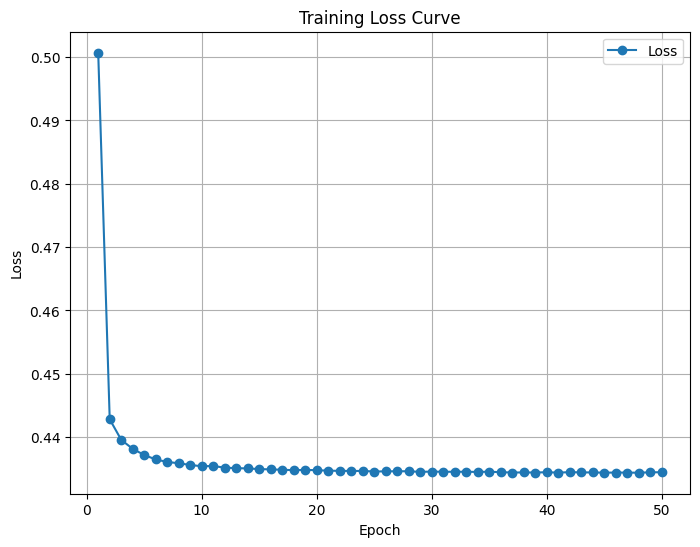

In [34]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# 自定义数据集类
class HyperspectralDataset(Dataset):
    def __init__(self, pca_data, patch_size=11, num_samples=1000):
        self.data = pca_data  # PCA 降维后的高光谱数据
        self.patch_size = patch_size
        self.num_samples = num_samples
        self.h, self.w = pca_data.shape[1], pca_data.shape[2]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = torch.randint(self.patch_size // 2, self.h - self.patch_size // 2, (1,)).item()
        y = torch.randint(self.patch_size // 2, self.w - self.patch_size // 2, (1,)).item()
        
        cube = extract_cube(self.data, x, y, (self.patch_size, self.patch_size))
        cube_tensor = torch.tensor(cube).permute(1, 2, 0)
        
        cube_a, cube_b = split_cube(cube_tensor)
        cube_a = cube_a.permute(2, 0, 1)
        cube_b = cube_b.permute(2, 0, 1)
        
        return cube_a, cube_b


class MultiPositivePatchDataset(Dataset):
    def __init__(self, pca_data, coords, patch_size=11):
        self.data = pca_data
        self.coords = coords
        self.patch_size = patch_size

        # 展平坐标：一个中心对应 4 个邻居位置
        self.flattened_coords = []
        for x, y in coords:
            self.flattened_coords += [
                (x, y, x-1, y),  # 上
                (x, y, x+1, y),  # 下
                (x, y, x, y-1),  # 左
                (x, y, x, y+1),  # 右
            ]

    def __len__(self):
        return len(self.flattened_coords)

    def __getitem__(self, idx):
        x1, y1, x2, y2 = self.flattened_coords[idx]
        patch_a = extract_cube(self.data, x1, y1, (self.patch_size, self.patch_size))
        patch_b = extract_cube(self.data, x2, y2, (self.patch_size, self.patch_size))
        patch_a = torch.tensor(patch_a, dtype=torch.float32)
        patch_b = torch.tensor(patch_b, dtype=torch.float32)
        return patch_a, patch_b

class MultiPositivePatchDataset1(Dataset):
    def __init__(self, pca_data, coords, patch_size=11):
        self.data = pca_data
        self.coords = coords
        self.patch_size = patch_size

        # 展平坐标：一个中心对应 4 个邻居位置
        self.flattened_coords = []
        for x, y in coords:
            self.flattened_coords += [
                (x, y, x-1, y),  # 上
                (x, y, x+1, y),  # 下
                (x, y, x, y-1),  # 左
                (x, y, x, y+1),  # 右
            ]

    def __len__(self):
        return len(self.flattened_coords)

    def __getitem__(self, idx):
        x1, y1, x2, y2 = self.flattened_coords[idx]
        patch_a = extract_cube(self.data, x1, y1, (self.patch_size, self.patch_size))
        patch_b = extract_cube(self.data, x2, y2, (self.patch_size, self.patch_size))
        
        patch_a = torch.tensor(patch_a, dtype=torch.float32)  # shape: (C, H, W)
        patch_b = torch.tensor(patch_b, dtype=torch.float32)

        # 拆分光谱维度 C
        C = patch_a.shape[0]
        c_half = C // 2
        a1, a2 = patch_a[:c_half], patch_a[c_half:]
        b1, b2 = patch_b[:c_half], patch_b[c_half:]

        # 组合成混合补丁
        patch_mix1 = torch.cat([a1, b1], dim=0)  # shape: (C, H, W)
        patch_mix2 = torch.cat([a2, b2], dim=0)

        return patch_mix1, patch_mix2
pca_data_tensor = torch.tensor(pca_data).float()
dataset = MultiPositivePatchDataset(pca_data_tensor, coords)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)  # 每 batch 会生成 64×4=256 对

# 初始化网络和优化器
feature_extractor = FeatureExtractor(input_channels=com).cuda()
projection_head = ProjectionHead(input_dim=128, output_dim=8).cuda()
optimizer = optim.Adam(list(feature_extractor.parameters()) + list(projection_head.parameters()), lr=1e-4)


# 训练循环
#os.mkdir('final')
num_epochs = 50
loss_values = []
temperature = 1.0

for epoch in range(num_epochs):
    feature_extractor.train()
    projection_head.train()
    epoch_loss = 0

    for cube_a, cube_b in dataloader:  #
        cube_a, cube_b = cube_a.cuda(), cube_b.cuda()

        # 提取特征
        features_a = feature_extractor(cube_a)
        features_b = feature_extractor(cube_b)

        # 投影
        proj_a = projection_head(features_a)
        proj_b = projection_head(features_b)

        # 计算对比损失
        loss = contrastive_loss_ce_hard_negatives(proj_a,proj_b, temperature=1, num_negatives=5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # 在第50、100、150轮存储模型
    if (epoch + 1) in [50, 100, 150]:
        model_path = f'final/Hous_lin_{epoch+1}_model1_60ep.pth'
        torch.save(
            {
                'epoch': epoch + 1,
                'feature_extractor_state_dict': feature_extractor.state_dict(),
                'projection_head_state_dict': projection_head.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            },
            model_path
        )
        print(f"Model saved at epoch {epoch+1} to {model_path}")

# 训练完成后绘制损失值曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.savefig('final/Hous_lin_50_model1_60ep.png')
plt.show()



In [35]:
def extract_labels(truth, label_dict):
    """
    从稀疏矩阵中提取标注数据，格式为 [(row, col, label), ...]。
    并将标签值映射到 [0, len(label_dict)-1] 的范围。
    """
    rows, cols, labels = truth.row, truth.col, truth.data
    # 创建从标签值到索引的映射
    label_to_index = {label_value: idx for idx, label_value in enumerate(label_dict.keys())}
    mapped_labels = [label_to_index[label] for label in labels if label in label_to_index]
    return [(row, col, label) for row, col, label in zip(rows, cols, mapped_labels)]


test_labels = extract_labels(test_truth, info['label_dict'])


print(f"Number of testing samples: {len(test_labels)}")


Number of testing samples: 12197


In [36]:
from collections import Counter


test_label_counts = Counter([label for _, _, label in test_labels])


print("Testing label distribution:", test_label_counts)


Testing label distribution: Counter({6: 1072, 1: 1064, 8: 1059, 3: 1056, 4: 1056, 10: 1054, 0: 1053, 7: 1053, 11: 1041, 9: 1036, 2: 505, 14: 473, 12: 285, 13: 247, 5: 143})


In [50]:
from torch.utils.data import Dataset, DataLoader
import random
from collections import defaultdict
import numpy as np
import torch
from sklearn.decomposition import PCA

# 提取立方块函数
def extract_cube(data, x, y, size):
    """
    从高光谱图像中提取一个立方块，并在边缘不足时进行填充。
    参数:
        data: 高光谱数据, 形状为 [C, H, W]
        x, y: 中心像素的坐标
        size: 立方块的大小 (s, s)
    返回:
        cube: 提取的立方块, 形状为 [C, s, s]
    """
    c, h, w = data.shape
    half_size = size[0] // 2
    x_min = max(0, x - half_size)
    x_max = min(h, x + half_size + 1)
    y_min = max(0, y - half_size)
    y_max = min(w, y + half_size + 1)
    
    cube = data[:, x_min:x_max, y_min:y_max]

    # 对称填充，确保形状为 (C, s, s)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (max(0, half_size - x), max(0, x + half_size + 1 - h)),  # 高度填充
        (max(0, half_size - y), max(0, y + half_size + 1 - w)),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="reflect")
    return cube


# PCA 降维函数
def apply_pca_train_only(hsi_data, train_truth, num_components=20):
    """
    使用训练区域的光谱数据训练 PCA 模型，并应用到整个数据集。
    参数:
        hsi_data: 高光谱数据, 形状为 [C, H, W]
        train_truth: coo_array, 训练区域的稀疏矩阵，表示训练样本的位置
        num_components: 保留的主成分数量
    返回:
        pca_data: 降维后的数据, 形状为 [num_components, H, W]
        explained_variance_ratio: PCA 的累计解释方差比
    """
    c, h, w = hsi_data.shape
    rows, cols = train_truth.row, train_truth.col  # 提取训练区域的行列索引

    # 提取训练区域的光谱数据 [num_samples, num_channels]
    train_spectra = hsi_data[:, rows, cols].T  # 转置为 [num_samples, num_channels]

    # 在训练区域数据上拟合 PCA
    pca = PCA(n_components=num_components)
    pca.fit(train_spectra)  # 仅在训练区域数据上训练 PCA

    # 转换整个数据集
    reshaped_data = hsi_data.reshape(c, -1).T  # [H×W, C]
    reduced_data = pca.transform(reshaped_data)  # 降维 [H×W, num_components]

    # 恢复为原始图像的形状
    pca_data = reduced_data.T.reshape(num_components, h, w)  # [num_components, H, W]
    
    return pca_data, pca.explained_variance_ratio_


# 分类数据集定义
class ClassificationDataset(Dataset):
    def __init__(self, data, labels, patch_size=11):
        """
        构造分类数据集。
        参数:
            data: PCA 降维后的数据 [C, H, W]
            labels: [(row, col, label), ...]，标注的样本
            patch_size: 立方块大小 (patch_size, patch_size)
        """
        self.data = data
        self.labels = labels
        self.patch_size = patch_size

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y, label = self.labels[idx]
        cube = extract_cube(self.data, x, y, (self.patch_size, self.patch_size))  # 提取立方块
        cube_tensor = torch.tensor(cube).float()  # 转换为浮点张量
        return cube_tensor, label


# 候选集生成函数
def create_candidate_dataset(train_labels, num_classes, samples_per_class):
    """
    从训练样本中按每类抽取指定数量的样本，构造候选集。
    参数:
        train_labels: 原始训练样本 [(row, col, label), ...]
        num_classes: 类别数量
        samples_per_class: 每个类别抽取的样本数量
    返回:
        candidate_labels: 候选样本 [(row, col, label), ...]
    """
    class_samples = defaultdict(list)
    for sample in train_labels:
        class_samples[sample[2]].append(sample)

    candidate_labels = []
    for cls in range(num_classes):
        if cls in class_samples:
            samples = class_samples[cls]
            if len(samples) < samples_per_class:
                print(f"Warning: Class {cls} has only {len(samples)} samples, less than {samples_per_class}.")
            candidate_labels.extend(random.sample(samples, min(samples_per_class, len(samples))))
        else:
            print(f"Warning: Class {cls} has no samples in training set.")
    return candidate_labels


def extract_labels(truth, label_dict):
    rows, cols, labels = truth.row, truth.col, truth.data
    # 标签从 1~15 映射为 0~14
    return [(r, c, label - 1) for r, c, label in zip(rows, cols, labels)]

num_classes = len(set(train_truth.data))

# 从稀疏矩阵 train_truth 中提取训练样本标签 [(row, col, label), ...]
train_labels = extract_labels(train_truth, info['label_dict'])
test_labels = extract_labels(test_truth, info['label_dict'])

# 应用 PCA（在训练区域上）
pca_data, explained_variance_ratio = apply_pca_train_only(casi, train_truth, num_components=20)

# 构造训练和测试数据集
train_dataset = ClassificationDataset(pca_data, train_labels, patch_size=11)

test_dataset = ClassificationDataset(pca_data, test_labels, patch_size=11)

# 定义 DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


加载对比学习训练的模型权重

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义特征提取器
class FeatureExtractor(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # Flatten to [batch_size, features]

# 加载对比学习的模型权重
#checkpoint_path = "./pth/model_epoch_160.pth"  # 修改为对比学习模型的路径
checkpoint_path = "final/Hous_lin_50_model1_20ep.pth"
checkpoint = torch.load(checkpoint_path)

# 确保权重文件中包含特征提取器的权重
if 'feature_extractor_state_dict' not in checkpoint:
    raise KeyError("Checkpoint does not contain 'feature_extractor_state_dict'. Please check the file.")



In [52]:
# 初始化特征提取器（与对比学习阶段一致的输入通道数为 20）
feature_extractor = FeatureExtractor(input_channels=20).cuda()

# 加载所有预训练权重
feature_extractor.load_state_dict(checkpoint['feature_extractor_state_dict'])
print("Loaded pre-trained weights for the entire feature extractor.")

# 检查冻结状态（设置所有层参数为可微调）
for param in feature_extractor.parameters():
    param.requires_grad = True  # 解冻所有参数

# 定义分类头

class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

# 修改输入维度为 128（特征提取器的输出维度）

classification_head = ClassificationHead(input_dim=128, num_classes=15).cuda()


# 定义优化器
optimizer = optim.Adam([
    {"params": feature_extractor.parameters(), "lr": 1e-4},  # 微调特征提取器
    {"params": classification_head.parameters(), "lr": 1e-3},  # 分类头
])

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 训练分类头和特征提取器
def train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=50):
    feature_extractor.train()  # 微调特征提取器
    classification_head.train()  # 训练分类头

    for epoch in range(num_epochs):
        epoch_loss = 0
        for cubes, labels in train_loader:
            cubes, labels = cubes.cuda(), labels.cuda().long()

            # 提取特征
            features = feature_extractor(cubes)

            # 分类头进行训练
            outputs = classification_head(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

# 运行训练函数
train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=200)


Loaded pre-trained weights for the entire feature extractor.
Epoch [1/200], Loss: 2.7285
Epoch [2/200], Loss: 2.3452
Epoch [3/200], Loss: 2.1501
Epoch [4/200], Loss: 1.9466
Epoch [5/200], Loss: 1.7633
Epoch [6/200], Loss: 1.6330
Epoch [7/200], Loss: 1.4997
Epoch [8/200], Loss: 1.4057
Epoch [9/200], Loss: 1.3275
Epoch [10/200], Loss: 1.2098
Epoch [11/200], Loss: 1.1650
Epoch [12/200], Loss: 1.1001
Epoch [13/200], Loss: 1.0328
Epoch [14/200], Loss: 1.0002
Epoch [15/200], Loss: 0.9275
Epoch [16/200], Loss: 0.8903
Epoch [17/200], Loss: 0.8611
Epoch [18/200], Loss: 0.8223
Epoch [19/200], Loss: 0.7636
Epoch [20/200], Loss: 0.7049
Epoch [21/200], Loss: 0.7190
Epoch [22/200], Loss: 0.6697
Epoch [23/200], Loss: 0.6148
Epoch [24/200], Loss: 0.6375
Epoch [25/200], Loss: 0.5971
Epoch [26/200], Loss: 0.5526
Epoch [27/200], Loss: 0.5474
Epoch [28/200], Loss: 0.5072
Epoch [29/200], Loss: 0.4856
Epoch [30/200], Loss: 0.4646
Epoch [31/200], Loss: 0.4354
Epoch [32/200], Loss: 0.4450
Epoch [33/200], Loss

In [53]:
import torch
from sklearn.metrics import cohen_kappa_score

def evaluate_classification_model_with_details(feature_extractor, classification_head, test_loader, num_classes):
    """
    评估分类模型的性能，并输出详细预测结果和分布。

    参数:
        feature_extractor: 冻结的特征提取器
        classification_head: 分类头
        test_loader: 测试数据加载器
        num_classes: 总类别数
    """
    feature_extractor.eval()
    classification_head.eval()

    correct = 0
    total = 0

    # 初始化预测计数，并移动到 GPU
    prediction_counts = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_correct = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_total = torch.zeros(num_classes, dtype=torch.int64).cuda()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for cubes, labels in test_loader:
            cubes, labels = cubes.cuda(), labels.cuda()

            # 提取特征并进行预测
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            _, predicted = torch.max(outputs, 1)

            # 更新统计信息
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            prediction_counts += torch.bincount(predicted, minlength=num_classes).cuda()

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

            # 保存详细信息
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall Accuracy
    overall_accuracy = correct / total

    # Average Accuracy (每个类别的平均准确率)
    average_accuracy = (class_correct.float() / class_total.float()).mean().item()

    # Per-class Accuracy
    per_class_accuracy = class_correct.float() / class_total.float()

    # Kappa 系数
    kappa = cohen_kappa_score(all_labels, all_predictions)

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Average Accuracy: {average_accuracy:.4f}")
    print(f"Kappa Coefficient: {kappa:.4f}")

    print("\nPrediction Distribution:")
    for cls, count in enumerate(prediction_counts.cpu()):  # 将分布从 GPU 移回 CPU
        print(f"Class {cls}: {count} predictions")

    print("\nPer-class Accuracy:")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"Class {cls}: {acc:.4f}")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"{acc:.4f}")
    return overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy.cpu().numpy()


# 调用示例
overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy = evaluate_classification_model_with_details(
    feature_extractor, classification_head, test_loader, num_classes=num_classes
)

Overall Accuracy: 0.7838
Average Accuracy: 0.7858
Kappa Coefficient: 0.7657

Prediction Distribution:
Class 0: 886 predictions
Class 1: 960 predictions
Class 2: 915 predictions
Class 3: 977 predictions
Class 4: 1099 predictions
Class 5: 172 predictions
Class 6: 1852 predictions
Class 7: 622 predictions
Class 8: 994 predictions
Class 9: 709 predictions
Class 10: 817 predictions
Class 11: 1151 predictions
Class 12: 349 predictions
Class 13: 256 predictions
Class 14: 438 predictions

Per-class Accuracy:
Class 0: 0.8224
Class 1: 0.8477
Class 2: 0.8594
Class 3: 0.9081
Class 4: 0.9744
Class 5: 0.7133
Class 6: 0.8881
Class 7: 0.5261
Class 8: 0.7762
Class 9: 0.5396
Class 10: 0.5977
Class 11: 0.8915
Class 12: 0.8702
Class 13: 0.7449
Class 14: 0.8266
0.8224
0.8477
0.8594
0.9081
0.9744
0.7133
0.8881
0.5261
0.7762
0.5396
0.5977
0.8915
0.8702
0.7449
0.8266


In [ ]:
import random
import numpy as np
import torch
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import pandas as pd

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def train_and_evaluate_once(seed, pca_data, train_labels, test_labels, checkpoint, num_classes, num_epochs=200):
    set_seed(seed)

    train_dataset = ClassificationDataset(pca_data, train_labels, patch_size=11)
    test_dataset = ClassificationDataset(pca_data, test_labels, patch_size=11)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    feature_extractor = FeatureExtractor(input_channels=40).cuda()
    classification_head = ClassificationHead(input_dim=128, num_classes=num_classes).cuda()
    feature_extractor.load_state_dict(checkpoint["feature_extractor_state_dict"])

    optimizer = torch.optim.Adam([
        {"params": feature_extractor.parameters(), "lr": 1e-4},
        {"params": classification_head.parameters(), "lr": 1e-3},
    ])
    criterion = torch.nn.CrossEntropyLoss()

    feature_extractor.train()
    classification_head.train()
    for _ in range(num_epochs):
        for cubes, labels in train_loader:
            cubes, labels = cubes.cuda(), labels.cuda().long()
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    feature_extractor.eval()
    classification_head.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for cubes, labels in test_loader:
            cubes, labels = cubes.cuda(), labels.cuda()
            outputs = classification_head(feature_extractor(cubes))
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    oa = accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    conf = confusion_matrix(all_labels, all_preds)
    class_acc = np.diag(conf) / conf.sum(axis=1)
    aa = np.nanmean(class_acc)

    return oa, aa, kappa, all_preds, all_labels, seed


# 运行评估
checkpoint_path = "pth/linyu_50_model1.pth"
checkpoint = torch.load(checkpoint_path)

results = []
best_result = None
best_oa = -1

for i in range(100):
    seed = 42 + i
    oa, aa, kappa, preds, labels, seed_used = train_and_evaluate_once(
        seed, pca_data, train_labels, test_labels, checkpoint, num_classes
    )
    results.append((seed, oa, aa, kappa))
    print(f"[{i+1}/100] Seed {seed} → OA: {oa:.4f}, AA: {aa:.4f}, Kappa: {kappa:.4f}")
    
    if oa > best_oa:
        best_oa = oa
        best_result = {
            "seed": seed,
            "oa": oa,
            "aa": aa,
            "kappa": kappa,
            "predictions": preds,
            "labels": labels
        }

# 输出最佳结果
print("\n🏆 最佳结果:")
print(f"Seed: {best_result['seed']}")
print(f"OA: {best_result['oa']:.4f}")
print(f"AA: {best_result['aa']:.4f}")
print(f"Kappa: {best_result['kappa']:.4f}")

# 保存预测结果（可选）
df = pd.DataFrame({
    "TrueLabel": best_result["labels"],
    "Predicted": best_result["predictions"]
})
df.to_csv(f"best_seed_{best_result['seed']}_results.csv", index=False)

print(f"已保存最佳预测结果至: best_seed_{best_result['seed']}_results.csv")
results_array = np.array(results)  # shape: (100, 4) (seed, oa, aa, kappa)
mean_oa = results_array[:, 1].mean()
mean_aa = results_array[:, 2].mean()
mean_kappa = results_array[:, 3].mean()

print("\n🔎 100 次重复实验的平均结果：")
print(f"平均 OA: {mean_oa:.4f}")
print(f"平均 AA: {mean_aa:.4f}")
print(f"平均 Kappa: {mean_kappa:.4f}")

[1/100] Seed 42 → OA: 0.7902, AA: 0.8037, Kappa: 0.7732
[2/100] Seed 43 → OA: 0.7994, AA: 0.8108, Kappa: 0.7829
[3/100] Seed 44 → OA: 0.7764, AA: 0.7831, Kappa: 0.7583
[4/100] Seed 45 → OA: 0.7899, AA: 0.8000, Kappa: 0.7729
[5/100] Seed 46 → OA: 0.7904, AA: 0.7960, Kappa: 0.7733
[6/100] Seed 47 → OA: 0.8028, AA: 0.8056, Kappa: 0.7867
[7/100] Seed 48 → OA: 0.7939, AA: 0.7976, Kappa: 0.7768
[8/100] Seed 49 → OA: 0.7949, AA: 0.7980, Kappa: 0.7780
[9/100] Seed 50 → OA: 0.7848, AA: 0.7992, Kappa: 0.7673
[10/100] Seed 51 → OA: 0.8090, AA: 0.8206, Kappa: 0.7930
[11/100] Seed 52 → OA: 0.7843, AA: 0.7909, Kappa: 0.7669
[12/100] Seed 53 → OA: 0.7813, AA: 0.7860, Kappa: 0.7636
[13/100] Seed 54 → OA: 0.7835, AA: 0.7884, Kappa: 0.7659
[14/100] Seed 55 → OA: 0.7910, AA: 0.8033, Kappa: 0.7741
[15/100] Seed 56 → OA: 0.7981, AA: 0.8038, Kappa: 0.7818
[16/100] Seed 57 → OA: 0.7932, AA: 0.8092, Kappa: 0.7758
[17/100] Seed 58 → OA: 0.8002, AA: 0.8118, Kappa: 0.7834
[18/100] Seed 59 → OA: 0.7848, AA: 0.789

In [25]:
import random
import numpy as np
import torch
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import pandas as pd

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False





   
seed = 125
set_seed(seed)
import torch
from sklearn.metrics import cohen_kappa_score

def evaluate_classification_model_with_details(feature_extractor, classification_head, test_loader, num_classes):
    """
    评估分类模型的性能，并输出详细预测结果和分布。

    参数:
        feature_extractor: 冻结的特征提取器
        classification_head: 分类头
        test_loader: 测试数据加载器
        num_classes: 总类别数
    """
    feature_extractor.eval()
    classification_head.eval()

    correct = 0
    total = 0

    # 初始化预测计数，并移动到 GPU
    prediction_counts = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_correct = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_total = torch.zeros(num_classes, dtype=torch.int64).cuda()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for cubes, labels in test_loader:
            cubes, labels = cubes.cuda(), labels.cuda()

            # 提取特征并进行预测
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            _, predicted = torch.max(outputs, 1)

            # 更新统计信息
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            prediction_counts += torch.bincount(predicted, minlength=num_classes).cuda()

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

            # 保存详细信息
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall Accuracy
    overall_accuracy = correct / total

    # Average Accuracy (每个类别的平均准确率)
    average_accuracy = (class_correct.float() / class_total.float()).mean().item()

    # Per-class Accuracy
    per_class_accuracy = class_correct.float() / class_total.float()

    # Kappa 系数
    kappa = cohen_kappa_score(all_labels, all_predictions)

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Average Accuracy: {average_accuracy:.4f}")
    print(f"Kappa Coefficient: {kappa:.4f}")

    print("\nPrediction Distribution:")
    for cls, count in enumerate(prediction_counts.cpu()):  # 将分布从 GPU 移回 CPU
        print(f"Class {cls}: {count} predictions")

    print("\nPer-class Accuracy:")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"Class {cls}: {acc:.4f}")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"{acc:.4f}")
    return overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy.cpu().numpy()


# 调用示例
overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy = evaluate_classification_model_with_details(
    feature_extractor, classification_head, test_loader, num_classes=num_classes
)


Overall Accuracy: 0.8162
Average Accuracy: 0.8232
Kappa Coefficient: 0.8003

Prediction Distribution:
Class 0: 876 predictions
Class 1: 974 predictions
Class 2: 491 predictions
Class 3: 1001 predictions
Class 4: 1101 predictions
Class 5: 135 predictions
Class 6: 2167 predictions
Class 7: 704 predictions
Class 8: 970 predictions
Class 9: 727 predictions
Class 10: 886 predictions
Class 11: 1167 predictions
Class 12: 306 predictions
Class 13: 199 predictions
Class 14: 493 predictions

Per-class Accuracy:
Class 0: 0.8196
Class 1: 0.8477
Class 2: 0.9683
Class 3: 0.8949
Class 4: 0.9706
Class 5: 0.7483
Class 6: 0.9030
Class 7: 0.6068
Class 8: 0.7592
Class 9: 0.5473
Class 10: 0.7296
Class 11: 0.9328
Class 12: 0.8737
Class 13: 0.7490
Class 14: 0.9979
0.8196
0.8477
0.9683
0.8949
0.9706
0.7483
0.9030
0.6068
0.7592
0.5473
0.7296
0.9328
0.8737
0.7490
0.9979
